# Chapter7
## Model Performance and Validation

In [2]:
import os, sys
import numpy as np
from math import floor, ceil
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from sample import Sample
from dataset import Dataset
from database import Database
from dataset_simulation import DatasetSimulation
from cfar_detector import CFARDetector
from nn_detector import NeuralNetworkDetector
from yolo_detector import YOLODetector
from cfar_detector_generator import CFARDetectorGenerator


dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
site = 'marion'
t_res, f_res = 0.006395061728395062, 0.15503875968992248
database = Database(dataset_loc, database_loc, site)
cfar_detector_gen = CFARDetectorGenerator(dataset_loc, database_loc, dataset_sim_loc, result_loc, site, t_res, f_res)

linewidth = 2
font_title = 32
font_legend = 20
font_label = 24
font_ticks = 18
font = [font_title, font_legend, font_label, font_ticks, linewidth] # [None]*5

In [2]:
files = database.get_train()

### Cross-Correlation using Whistler Kernel (CCWK)

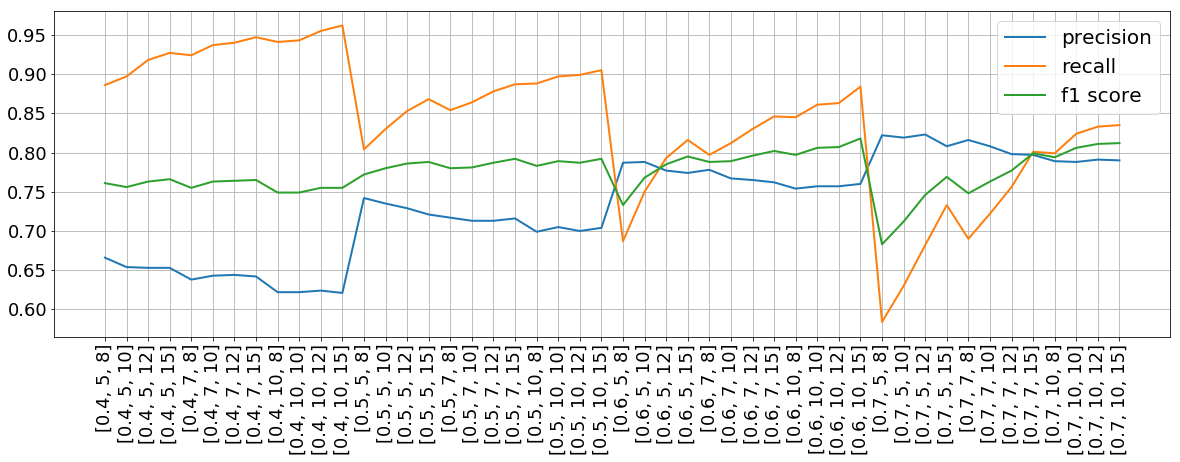

[650, 205, 85, 0]
[589, 150, 146, 0]
[614, 163, 121, 0]


In [17]:
n = 200
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 10,7,9,0,0,0.5

# for N in [8,10,12,15]:
#     for G in [5,7,10]:
#         for X_dB in [0.4,0.5,0.6,0.7]:
#             cfar_detector_gen.dataset_cross_correlation_gen(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
#                                            An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
#                                            train=True, n=n)
x_axis = []
recall, precision, f1_score = [],[],[]
results = {}
for X_dB in [0.4,0.5,0.6,0.7]:
    for G in [5,7,10]:
        for N in [8,10,12,15]:
#             print([N,G,X_dB])
            data = cfar_detector_gen.dataset_cross_correlation_load(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
            confusion_matrix = data['confusion matrix']
            x_axis.append([X_dB,G,N])
            results[str([X_dB,G,N])]=confusion_matrix
#             print(confusion_matrix)
            performance = cfar_detector_gen.performance(confusion_matrix)
            recall.append(performance['recall'])
            precision.append(performance['precision'])
            f1_score.append(performance['f1 score'])
#             print(performance)
plt.figure(figsize=(20,6))
plt.plot(precision,linewidth=font[-1])
plt.plot(recall,linewidth=font[-1])
plt.plot(f1_score,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation='vertical', fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.legend(['precision','recall','f1 score'], fontsize=font[1])
plt.grid(True)
plt.show()
print(results[str([0.6,10,15])])
print(results[str([0.7,7,15])])
print(results[str([0.7,10,15])])

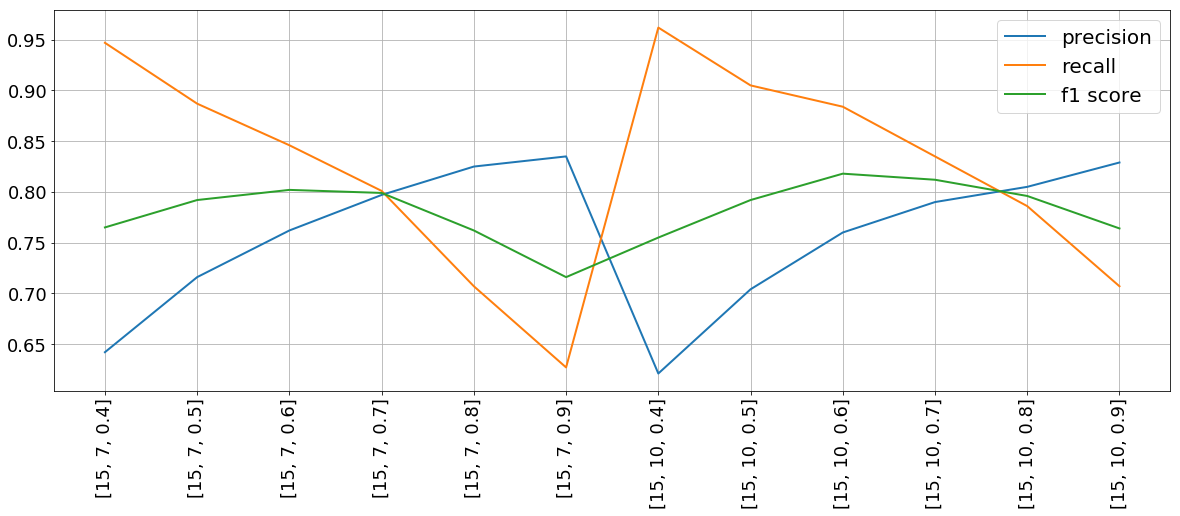

In [21]:
n = 200
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 15,10,9,0,0,0.5

# for N in [15]:
#     for G in [7,10]:
#         for X_dB in [0.4,0.5,0.6,0.7,0.8,0.9]:
#             cfar_detector_gen.dataset_cross_correlation_gen(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
#                                            An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
#                                            train=True, n=n)
x_axis = []
recall, precision, f1_score = [],[],[]
for N in [15]:
    for G in [7,10]:
        for X_dB in [0.4,0.5,0.6,0.7,0.8,0.9]:
            x_axis.append([N,G,X_dB])
            data = cfar_detector_gen.dataset_cross_correlation_load(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
            confusion_matrix = data['confusion matrix']
            performance = cfar_detector_gen.performance(confusion_matrix)
            recall.append(performance['recall'])
            precision.append(performance['precision'])
            f1_score.append(performance['f1 score'])

plt.figure(figsize=(20,7))
plt.plot(precision,linewidth=font[-1])
plt.plot(recall,linewidth=font[-1])
plt.plot(f1_score,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation='vertical', fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.legend(['precision','recall','f1 score'], fontsize=font[1])
plt.grid(True)
plt.show()

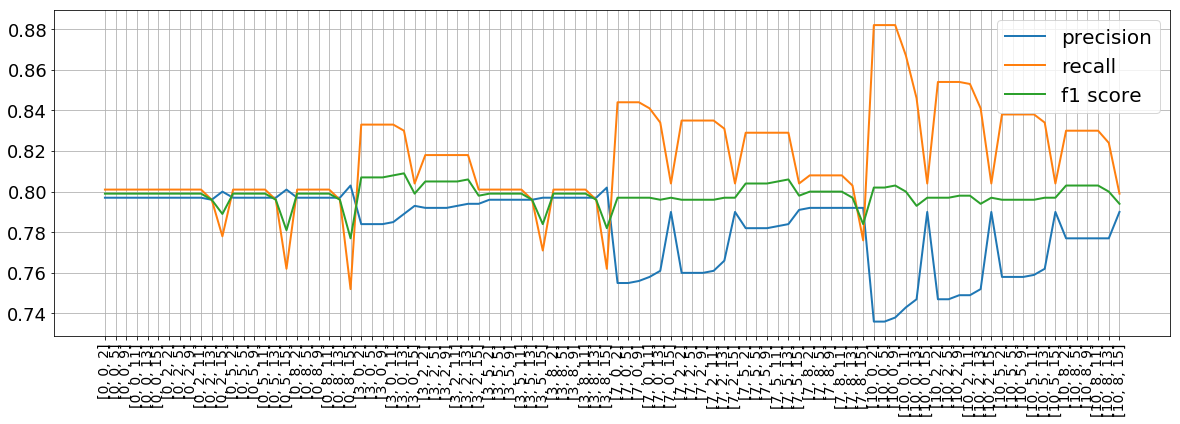

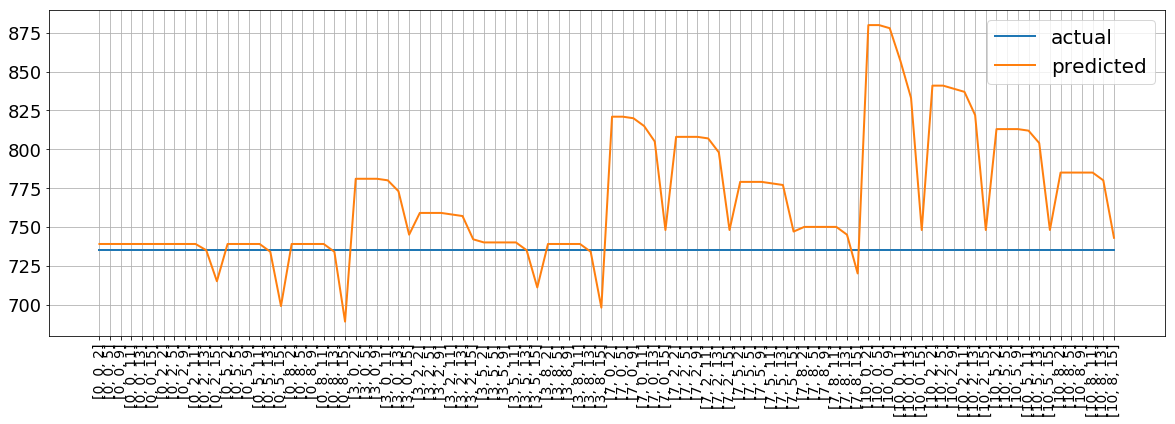

In [10]:
n = 200
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 15,7,9,0,0,0.7

# for k in [2, 5,9,11,13,15]:
#     for Ts in [0,2,5,8]:
#         for Tl in [0,3,7,10]:
#             cfar_detector_gen.dataset_cross_correlation_gen(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
#                                            An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
#                                            train=True, n=n)
x_axis = []
recall, precision, f1_score = [],[],[]
actual, predicted = [],[]
for Tl in [0,3,7,10]:
    for Ts in [0,2,5,8]:
        for k in [2, 5,9,11,13,15]:
            x_axis.append([Tl,Ts,k])
            data = cfar_detector_gen.dataset_cross_correlation_load(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
            confusion_matrix = data['confusion matrix']
            actual.append(confusion_matrix[0]+confusion_matrix[2])
            predicted.append(confusion_matrix[0]+confusion_matrix[1])
            performance = cfar_detector_gen.performance(confusion_matrix)
            recall.append(performance['recall'])
            precision.append(performance['precision'])
            f1_score.append(performance['f1 score'])

plt.figure(figsize=(20,6))
plt.plot(precision,linewidth=font[-1])
plt.plot(recall,linewidth=font[-1])
plt.plot(f1_score,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation='vertical', fontsize=font[3]-4)
plt.yticks(fontsize=font[3])
plt.legend(['precision','recall','f1 score'], fontsize=font[1])
plt.grid(True)
plt.show()
plt.figure(figsize=(20,6))
plt.plot(actual,linewidth=font[-1])
plt.plot(predicted,linewidth=font[-1])
plt.xticks(list(range(len(x_axis))),x_axis, rotation='vertical', fontsize=font[3]-4)
plt.yticks(fontsize=font[3])
plt.legend(['actual','predicted'], fontsize=font[1])
plt.grid(True)
plt.show()

In [3]:
n = None
f_min, f_max = 1.5, 9.5
N,G,k,Ts,Tl,X_dB = 12,7,13,4,0,0.6

cfar_detector_gen.dataset_cross_correlation_gen(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
data = cfar_detector_gen.dataset_cross_correlation_load(transforms='zscore', transforms_params=None, f_min=f_min, f_max=f_max, 
                                           An=0.35, D0=80, magnitude=1, N=N, G=G, k=k, Ts=Ts, Tl=Tl, X_dB=X_dB,
                                           train=True, n=n)
confusion_matrix = data['confusion matrix']
performance = cfar_detector_gen.performance(confusion_matrix)
print(confusion_matrix)
print(performance)
data['results']

exists?  True
(zscore,None)_(1.5,9.5)_(0.35,80,1)_(12,7,13,4,0,0.6)_(True,None,1).corr alreadyh exists
[3966, 1199, 1152, 0]
{'recall': 0.775, 'precision': 0.768, 'f1 score': 0.771, 'g measure': 0.771, 'false alarm': 0.232, 'misdetection': 0.225}


{'2013-07-10UT22:51:09.06211938.marion.vr2': [[2.0, 2.2, 2.3], [], [0.3], []],
 '2013-06-28UT01:05:06.84771922.marion.vr2': [[2.2, 2.3],
  [2.1],
  [0.0, 0.1, 0.2, 0.3, 0.4],
  []],
 '2013-07-11UT01:19:10.57251938.marion.vr2': [[], [], [0.3, 2.2], []],
 '2013-07-07UT14:48:18.20771914.marion.vr2': [[5.0, 5.1], [], [2.2, 2.7], []],
 '2013-07-02UT16:36:17.87491914.marion.vr2': [[2.2, 2.3, 2.4],
  [],
  [0.7, 0.9],
  []],
 '2013-10-08UT00:03:09.39699422.marion.vr2': [[2.2, 2.3, 2.6], [], [], []],
 '2013-07-04UT18:49:09.30531930.marion.vr2': [[2.3, 2.4], [], [], []],
 '2013-07-27UT16:48:30.34211914.marion.vr2': [[4.2, 4.3, 4.5], [], [], []],
 '2013-07-02UT14:26:13.40771914.marion.vr2': [[0.7,
   2.2,
   2.3,
   2.5,
   2.6,
   2.7,
   2.8],
  [0.6],
  [],
  []],
 '2013-05-09UT18:56:20.91109664.marion.vr2': [[4.6, 4.9],
  [4.5],
  [2.2, 2.3],
  []],
 '2013-06-28UT01:09:00.98531922.marion.vr2': [[], [], [2.2, 2.3, 2.4], []],
 '2013-06-25UT03:52:18.36131922.marion.vr2': [[1.7, 1.8, 2.2, 2.3],
